#### Code to calculate cloud fraction diurnal cycle from 28.01 to 04.02
#### Author: Claudia Acquistapace
#### date: 08/12/2021
#### method: 
- read the w band files between 28.01 and 04.02 
- drop all fields other than reflectivity
- merge the data and filter out the rainy columns
- calculate mean grouped Ae every 1 min.
- calculate cloud fraction diurnal cycle with a pace of 10 min


In [1]:
# importing necessary libraries
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib
import numpy as np
import xarray as xr
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import glob
from myFunctions import lcl
from myFunctions import f_closest
from warnings import warn
import numpy as np
import pandas as pd
import atmos
import datetime as dt
import matplotlib.pyplot as plt
from scipy import interpolate
import custom_color_palette as ccp
from matplotlib import rcParams
import matplotlib.ticker as ticker



def f_calc_tot_cloud_fraction(matrix):
    '''
    function to calculate the total cloud fraction of a matrix (time, height)
    

    Parameters
    ----------
    matrix : ndarray (time, height)
        DESCRIPTION. reflectivity values

    Returns
    -------
    cloud fraction ndarray(time)

    '''
    #defining ndarray to contain cloud fraction
    cloud_fraction = []
    N_tot = matrix.shape[0]
    for ind_height in range(matrix.shape[1]):
        cloud_fraction.append(np.sum(~np.isnan(matrix[:,ind_height]))/N_tot)


    return(np.asarray(cloud_fraction))

In [2]:
# reading data containing flags to filter out rainy columns
flag_file_list = np.sort(glob.glob('/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/post_processed_data/*_flags_cloud_properties.nc'))
flag_file_list = flag_file_list[8:15]
flag_file_list

array(['/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/post_processed_data/20200128_flags_cloud_properties.nc',
       '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/post_processed_data/20200129_flags_cloud_properties.nc',
       '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/post_processed_data/20200130_flags_cloud_properties.nc',
       '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/post_processed_data/20200131_flags_cloud_properties.nc',
       '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/post_processed_data/20200201_flags_cloud_properties.nc',
       '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/post_processed_data/20200202_flags_cloud_properties.nc',
       '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/post_processed_data/20200203_flags_cloud_properties.nc'],
      dtype='<U114')

In [3]:
# reading radar file list
file_list = np.sort(glob.glob("/Volumes/Extreme SSD/ship_motion_correction_merian/corrected_data/wband_daily_with_DOI/latest/with_DOI/daily_intake/*.nc"))
file_list = file_list[9:16]
radar_data_dc = xr.open_mfdataset(file_list)
time = pd.to_datetime(radar_data_dc.time.values)
height = radar_data_dc.height.values
ze = radar_data_dc.radar_reflectivity.values

# converting ze to linear units for averaging
ze_lin = np.exp(ze/10.)

# defining a xarray dataset for ze
dims             = ['time','height']
coords           = {"time":time, "height":height}

ze_lin           = xr.DataArray(dims=dims, coords=coords, data=ze_lin,
                         attrs={'long_name':'radar reflectivity in linear units',
                                'units':''})

variables         = {'ze':ze_lin}
global_attributes = {'CREATED_BY'       : 'Claudia Acquistapace',
                    'CREATED_ON'       :  str(datetime.now()),
                    'FILL_VALUE'       :  'NaN', 
                    'PI_NAME'          : 'Claudia Acquistapace',
                    'PI_AFFILIATION'   : 'University of Cologne (UNI), Germany', 
                    'PI_ADDRESS'       : 'Institute for geophysics and meteorology, Pohligstrasse 3, 50969 Koeln', 
                    'PI_MAIL'          : 'cacquist@meteo.uni-koeln.de',
                    'DATA_DESCRIPTION' : 'Ze in linear units for calculating cloud fraction diurnal cycle',
                    'DATA_DISCIPLINE'  : 'Atmospheric Physics - Remote Sensing Lidar Profiler',
                    'DATA_GROUP'       : 'Experimental;Profile;Moving',
                    'DATA_SOURCE'      : 'w band data',
                    'DATA_PROCESSING'  : 'https://github.com/ClauClouds/SST-impact/',
                    'INSTRUMENT_MODEL' : 'w-band radar',
                     'COMMENT'         : 'original data postprocessed by Claudia Acquistapace' }
dataset    = xr.Dataset(data_vars = variables,
                        coords = coords,
                        attrs = global_attributes)




In [4]:
# filtering rainy columns from the data
flag_data = xr.open_mfdataset(flag_file_list)
flag_data_interp = flag_data.interp(time=dataset['time'].values, method='nearest')

# building a mask to filter out Ze rainy columns and substitute them with nans
# set to nan the values out of the thresholds for the selected variable
mask = np.zeros(len(flag_data_interp.time.values))
mask[np.where((flag_data_interp["flag_rain_ground"].values == 1) | (flag_data_interp["flag_rain"].values == 1))[0]] = 1 

dataset_no_rain = dataset.sel(time=time[mask == 0])

In [5]:
# re-writing time array as hh:mm for then being able to group
dataset_no_rain['time'] = pd.to_datetime(dataset_no_rain.time.values).strftime("%H:%M")

# grouping and calculating mean of the profiles
dataset_1min = dataset_no_rain.groupby('time').mean()


# generating time array of 10 min time resolution 
time_start = datetime(2020,1,20,0,0,0)
time_end = datetime(2020,1,20,23,59,59)
time_cf = pd.date_range(start=time_start, end=time_end, freq='15min')

# assigning time array with 1min resolution to the dataset_1min
dataset_1min['time'] = pd.date_range(start=time_start, end=time_end, freq='1min')

In [6]:
# calculating diurnal cycle of the cloud fraction
cloud_fraction_dc = np.zeros((len(time_cf), len(height)))

for ind_time in range(len(time_cf)-1):
    
    # calculate time extremes
    time_start = time_cf[ind_time]
    time_end = time_cf[ind_time+1]
    
    # selecting the data
    slice_ze = dataset_1min.sel(time=slice(time_start,time_end))
    
    # calculating cloud fraction as the sum of the ze different than nan divided by the number of time stamps in the interval
    cloud_fraction_dc[ind_time,:] = np.nansum(slice_ze.ze.values, axis=0)/len(np.nansum(slice_ze.ze.values, axis=0))

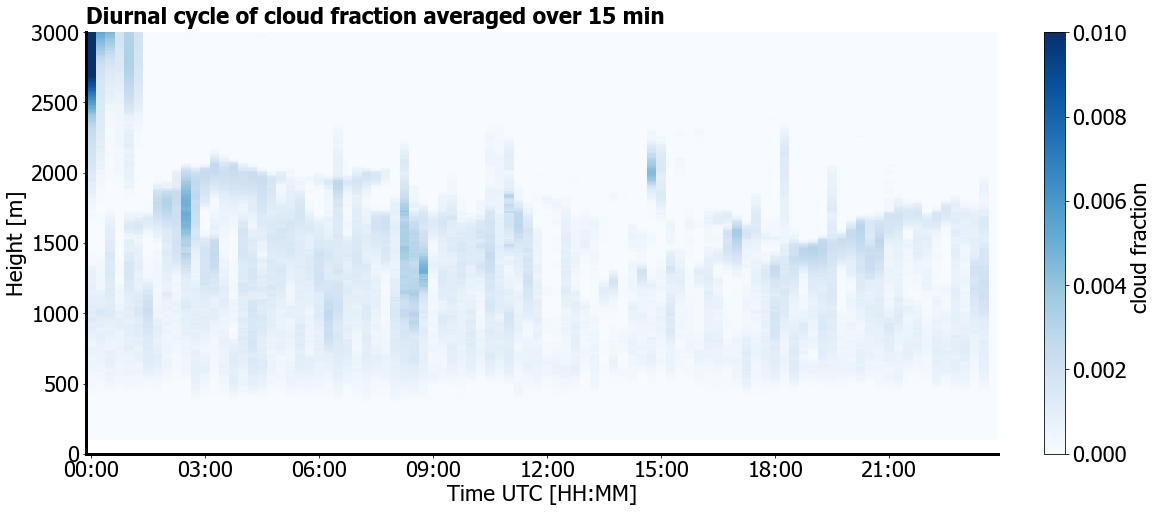

In [7]:
# plot of the diurnal cycle calculated
path_out_plots = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/SST_impact_work/plots/'
dict_plot_settings = {
    'labelsizeaxes':14,
    'fontSizeTitle':16,
    'fontSizeX'    :16,
    'fontSizeY'    :16,
    'cbarAspect'   :10,
    'fontSizeCbar' :16,
    'rcparams_font':['Tahoma'],
    'savefig_dpi'  :100,
    'font_size'    :22, 
    'grid'         :True}

# plots settings to be used
labelsizeaxes   = dict_plot_settings['labelsizeaxes']
fontSizeTitle   = dict_plot_settings['fontSizeTitle']
fontSizeX       = dict_plot_settings['fontSizeX']
fontSizeY       = dict_plot_settings['fontSizeY']
cbarAspect      = dict_plot_settings['cbarAspect']
fontSizeCbar    = dict_plot_settings['fontSizeCbar']
rcParams['font.sans-serif'] = dict_plot_settings['rcparams_font']
matplotlib.rcParams['savefig.dpi'] = dict_plot_settings['savefig_dpi']
plt.rcParams.update({'font.size':dict_plot_settings['font_size']})
grid = dict_plot_settings['grid']

fig2, axs = plt.subplots(1,1, figsize=(16,7), constrained_layout=True)
axs.spines["top"].set_visible(False)
axs.spines["right"].set_visible(False)
axs.spines["bottom"].set_linewidth(3)
axs.spines["left"].set_linewidth(3)
grid=True
mesh1 = axs.pcolormesh(time_cf, dataset_1min['height'].values, \
                             cloud_fraction_dc.T, vmin=0., \
                             vmax=0.01, cmap='Blues', rasterized=True)
cbar = fig2.colorbar(mesh1, ax=axs, label='cloud fraction ', \
                        location='right', aspect=20, use_gridspec=grid)
axs.set_xlabel('Time UTC [HH:MM]')
axs.set_ylim(0.,3000.)
axs.set_ylabel('Height [m]')
axs.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
axs.text(0, 1.02, 'Diurnal cycle of cloud fraction averaged over 15 min', \
            fontweight='black', transform=axs.transAxes)
fig2.savefig(path_out_plots+'cloud_fraction_diurnal_cycle.png')

In [8]:
# building xarray dataset for cloud fraction to apply then the mean operatore
path_out = path_out ='/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/post_processed_data/arthus_diurnal_cycle/'

dims = ['time', 'height']
coords = {'time':time_cf, 'height':dataset_1min['height'].values}
cf = xr.DataArray(dims=dims, coords=coords, data=cloud_fraction_dc,
                 attrs={'long_name':'cloud fraction diurnal cycle',
                        'units':''})
variables={'cloud_fraction':cf}

cf_dataset =xr.Dataset(data_vars = variables,
                       coords = coords)
cf_dataset.to_netcdf(path_out+'cloud_fraction_diurnal_cycle.nc')